# Classical SVC using a RBF-Kernel 

$\blacktriangleright$ This is part **I** of a notebook series demonstrating the functionality of the <code>QMLab</code>-Package. 


### Binary classification on biomedical data

We want to perform binary classification of the **SOBAR-Dataset** - a biomedical dataset about Cervical Cancer.

The original datset consists of 72 training examples and 19 features. 51 of the patients are tested negatively and 
21 are tested positive.

Just like most of the 9 datasets we're dealing with we do not have a huge amount of examples as well as an imbalance in the data, i.e. the class of positive tested patients is dominating the class of negatively tested ones.

Also the data is not separable by a linear classifier, meaning we'll have to use the **kernel trick** to map our data into a higher dimensional 
Hilbert space.


In [1]:
import numpy as np

from qmlab.preprocessing import parse_biomed_data_to_ndarray, reduce_feature_dim
from qmlab.plots.plot_data import plot_2d_data_with_train_test_split
from qmlab.plots.plot_model import plot_decision_boundaries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from qiskit_algorithms.utils import algorithm_globals

%matplotlib inline

In [2]:
random_state = 12345 
algorithm_globals.random_seed = random_state
np.random.seed(random_state)

In [3]:
X, y = parse_biomed_data_to_ndarray("sobar_new")
X = reduce_feature_dim(X, num_features=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50, 2)
(22, 2)
(50,)
(22,)


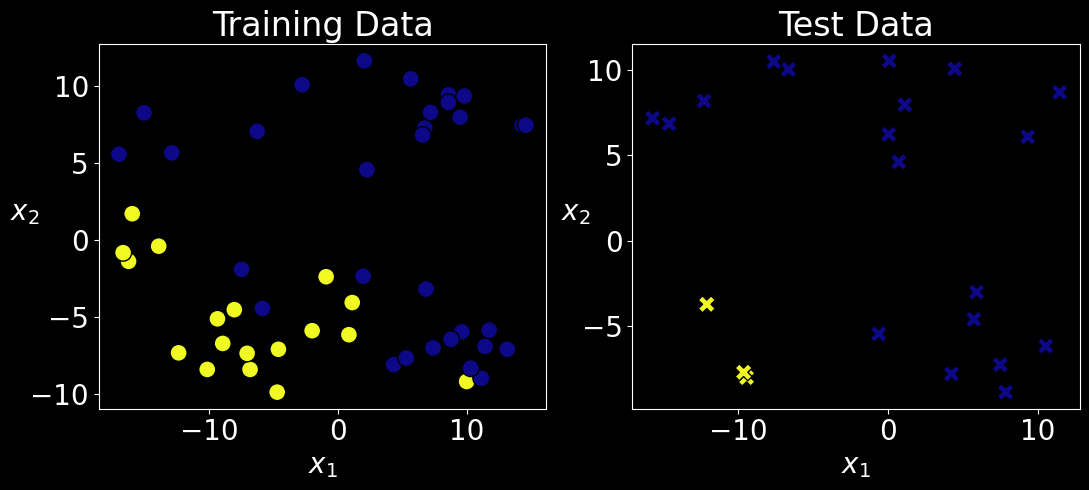

In [4]:
plot_2d_data_with_train_test_split(X_train, y_train, X_test, y_test, separate_plots=True)

### Classical Support Vector Machines
Support vector machines are a supervised learning algorithm.

They propose a model of the form 
$$
f(\mathbf{x}) = \mathbf{\theta}^\top \mathbf{x} + b
$$
called the **hyperplane**, which can separate data linearly in the dimension of the feature space $\mathbb{R}^d$.

The representatives of each class that have the closest distance to the hyperplane are the **support vectors**.

The distance between the hyperplane and the support vectors is called the **margin**.

&rarr; We're trying to find the hyperplane that separates the data while maximizing the margin.


The resulting optimization problem has an equivalent dual formulation: 
$$
f(\mathbf{x}) = \sum_{i=1}^n \alpha_i y_i \left(\mathbf{x_i}^\top \mathbf{x}\right) + b 
$$
where $n$ denotes the number of training examples in our data.

The true power of support vector machines lays in this formulation as we are able to replace the inner product of $\mathbb{R}^d$ by the inner product of a higher dimensional Hilbert space $\mathcal{F}$: 

$$
f(\mathbf{x}) = \sum_{i=1}^n \alpha_i y_i \left(\phi(\mathbf{x_i})^\top \phi(\mathbf{x})\right)+ b.
$$

This method is called the **kernel trick** and we define 

$$
\kappa(\mathbf{x},\mathbf{x}_i) \equiv \phi(\mathbf{x_i})^\top \phi(\mathbf{x}).
$$

As already mentioned above the kernel trick is going to be helpful for us since the data cannot be separated linearly:

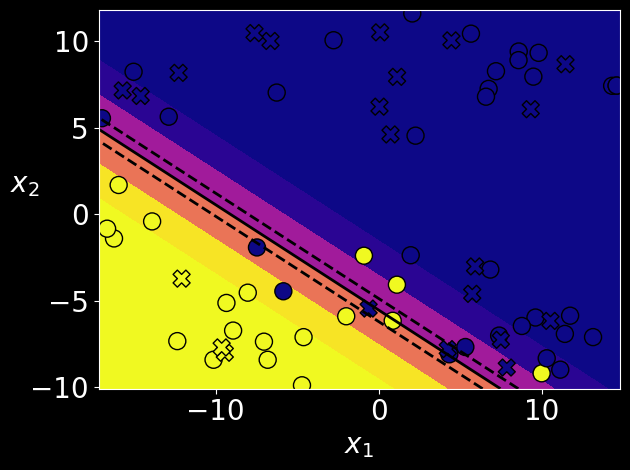

In [5]:
svm = SVC(kernel="linear", random_state=random_state)
svm.fit(X_train, y_train)
plot_decision_boundaries(svm, X_train, y_train, X_test, y_test)

The kernel that we work with in particular is called the **radial basis function** or **RBF kernel**. It takes on the form 
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp \left( - \gamma \left\| \mathbf{x}_j - \mathbf{x}_i\right\|^2 \right)
$$
for two data vectors $\mathbf{x}_i, \mathbf{x}_j \in \mathbb{R}^d$. 


This kernel is of particular interest for us because it gives rise to an infinite dimensional feature map:

\begin{align*}
e^{-\gamma \left\|\mathbf{x}_i - \mathbf{x}_j\right\|^2}
&= e^{-\gamma \left\|\mathbf{x}_i\right\|^2} e^{-\gamma \left\|\mathbf{x}_j\right\|^2} 
   e^{2\gamma \mathbf{x}_i^\top \mathbf{x}_j} \\
&= \sum_{j=0}^\infty \frac{(2\,\gamma \,\mathbf{x}_i^\top \mathbf{x}_j)^j}{j!} e^{-\gamma \left\|\mathbf{x}_i\right\|^2} e^{-\gamma \left\|\mathbf{x}_j\right\|^2} \\
&= \sum_{j=0}^\infty \left(\frac{\sqrt{2\,\gamma}}{\left(j!\right)^{1/(2j)}} e^{\frac{\gamma}{j}\left\|\mathbf{x}_i\right\|^2}
\frac{\sqrt{2\,\gamma}}{\left(j!\right)^{1/(2j)}} e^{\frac{\gamma}{j}\left\|\mathbf{x}_j\right\|^2} \mathbf{x}_i^\top \mathbf{x}_j 
\right)^j \\
&= \sum_{j=0}^\infty \sum_{\sum_i n_i = j}\frac{\sqrt{2\,\gamma}}{\left(j!\right)^{1/(2j)}} e^{\frac{\gamma}{j}\left\|\mathbf{x}_i\right\|^2} \binom{j}{n_1, \ldots, n_k}^{1/2} x_{i_1}^{n_1} \cdots x_{i_k}^{n_k} \frac{\sqrt{2\,\gamma}}{\left(j!\right)^{1/(2j)}} e^{\frac{\gamma}{j}\left\|\mathbf{x}_j\right\|^2} \binom{j}{n_1, \ldots, n_k}^{1/2} x_{j_1}^{n_1} \cdots x_{j_k}^{n_k}.
\end{align*}

$$
\implies \phi(\mathbf{x}_i) = \left(\frac{\sqrt{2\,\gamma}}{\left(j!\right)^{1/(2j)}} e^{\frac{\gamma}{j}\left\|\mathbf{x}_i\right\|^2} \binom{j}{n_1, \ldots, n_k}^{1/2} x_{i_1}^{n_1} \cdots x_{i_k}^{n_k}\right)_{j=0, \ldots, \infty, \sum_i n_i = j} .
$$

Best grid search parameters: {'C': 2, 'gamma': 0.1}
Best training score: 0.94


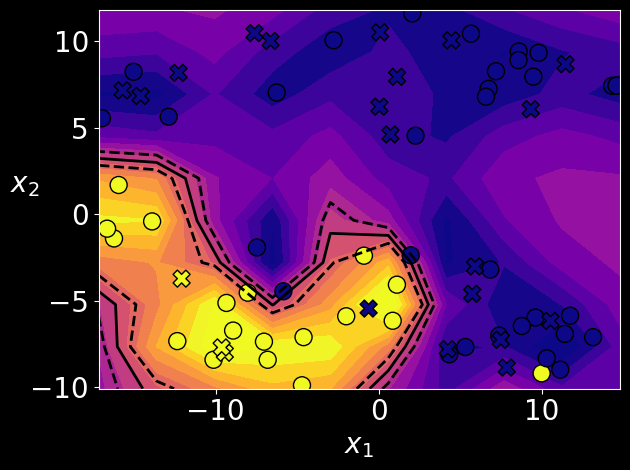

In [6]:
param_grid = {
    "gamma": [
        0.001,
        0.005,
        0.01,
        0.05,
        0.1,
        0.25,
        0.5,
        1.0,
        1.2,
        1.4,
        1.6,
        1.8,
        2.0,
        5.0,
        10.0,
    ],
    "C": [1, 2, 4, 6, 8, 10, 100],
}
gs = GridSearchCV(
    estimator=SVC(kernel="rbf", random_state=random_state),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=4,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state),
)
gs.fit(X_train, y_train)

print("Best grid search parameters:", gs.best_params_)
print("Best training score:", gs.best_score_)
clf = gs.best_estimator_

clf.fit(X_train, y_train)

plot_decision_boundaries(clf, X_train, y_train, X_test, y_test)

In [7]:
y_pred = clf.predict(X_train)
training_acc = metrics.balanced_accuracy_score(y_train, y_pred)
y_pred = clf.predict(X_test)
test_acc = metrics.balanced_accuracy_score(y_test, y_pred)
print("Prediction scores: \n")
print("\t\tTrain\tTest")
print(f"Accuracy:\t{training_acc:.2f}\t{test_acc:.2f}")

Prediction scores: 

		Train	Test
Accuracy:	0.97	0.97


Let's see what a polynomial kernel results in